In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

import torch
from torch import optim

from bliss.models import encoder
from bliss.datasets import sdss

In [2]:
import sys
sys.path.insert(0, '../sdss_galaxies/')
from sparse_field_lib import load_data

In [3]:
sys.path.insert(0, './utils/')
import source_simulator_lib
import dataset_lib
import catalog_optimizer_lib

from plotting_utils import plot_residuals
from which_device import device

In [4]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

catalog_file = '../sdss_galaxies/coadd_field_catalog_runjing_liu.fit'

# Load data

In [5]:
image, fits_file, wcs_list, sdss_data = load_data(sdss_dir=sdss_dir, 
                                                  catalog_file = catalog_file)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '19/09/98' to '1998-09-19''. [astropy.wcs.wcs]


In [6]:
background = sdss_data[0]['background']

In [7]:
# true locations
wcs = wcs_list[0]
px, py = wcs.all_world2pix(fits_file['ra'][:], fits_file['dec'][:], 0)

In [8]:
# true fluxes 
rmags = fits_file['psfmag_r'][:]
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'].mean()
rfluxes = dataset_lib._convert_mag_to_nmgy(rmags) * nelec_per_nmgy

(array([ 15.,  24.,  39.,  65., 185., 327., 183.,  51.,   8.,   4.]),
 array([14.82208 , 16.112719, 17.403358, 18.693998, 19.984638, 21.275278,
        22.565918, 23.856556, 25.147196, 26.437836, 27.728476],
       dtype=float32),
 <BarContainer object of 10 artists>)

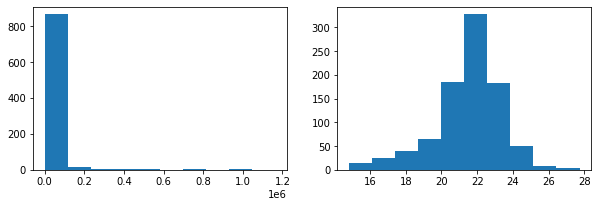

In [9]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].hist(rfluxes);
ax[1].hist(rmags)

In [10]:
# galaxy / star classification 
is_star = fits_file['probpsf'][:] == 1

print(is_star.mean())

0.38401775804661487


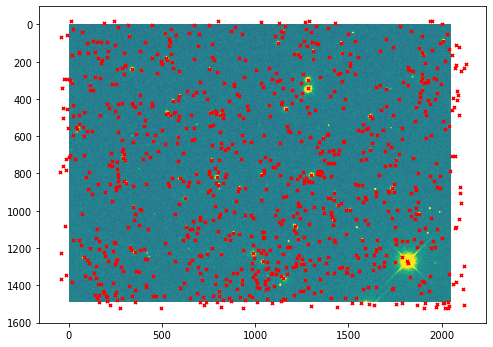

In [11]:
%matplotlib inline
plt.figure(figsize=(8,8))
vmin = np.percentile(image.flatten(), 1)
vmax = np.percentile(image.flatten(), 99)

plt.imshow(image[0], vmin=vmin, vmax=vmax)
plt.scatter(px, py, marker='x', color='r', s=10)

# Load PSF

In [12]:
sdss_psf = sdss.SdssPSF(psf_file, [2])

psf = sdss_psf.psf_at_points(0, 0., 0.)

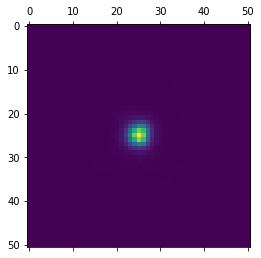

In [13]:
plt.matshow(psf)

# The encoder

In [14]:
from bliss.sleep import SleepPhase

In [15]:
slen = 100
max_detections = 2
n_bands = 1
tile_slen = 4
ptile_slen = 52


encoder_kwargs = dict(max_detections = max_detections,
                      n_bands = 1,
                      tile_slen = tile_slen,
                      ptile_slen = ptile_slen)

# doesn't matter -- we will use our own decoder. 
# just set it up so the init works
decoder_kwargs = dict(max_sources = 2,
                      slen = slen,
                      ptile_slen = ptile_slen, 
                      tile_slen = tile_slen, 
                      psf_params_file = '../../data/fitted_powerlaw_psf_params.npy')

In [16]:
sleep_net = SleepPhase(encoder_kwargs = encoder_kwargs, 
                       decoder_kwargs = decoder_kwargs).to(device)

In [17]:
sleep_net.image_encoder.load_state_dict(torch.load('./starnet')); 
sleep_net.eval();

# Get image chunck

In [18]:
clen = 200

x0 = 450
y0 = 350

# clen = 50
# x0 = 100
# y0 = 310

xlim = (x0, x0 + clen)
ylim = (y0, y0 + clen)
print('coordinates: ', xlim, ylim)

image_chunk = image[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]
background_chunk = background[0, ylim[0]:ylim[1], xlim[0]:xlim[1]]

# restrict to 200x200 chunk 
keep = (px > xlim[0]) & (px < xlim[1]) & (py < ylim[1]) & (py > ylim[0])

print('n sources: ', keep.sum())

coordinates:  (450, 650) (350, 550)
n sources:  11


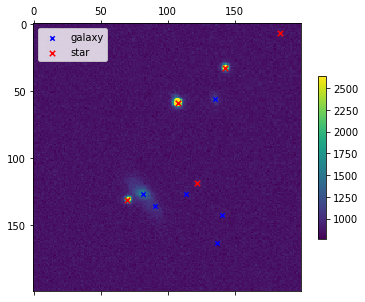

In [19]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))


p_level = 0.1
vmin = np.percentile(image_chunk.flatten(), p_level)
vmax = np.percentile(image_chunk.flatten(), 100-p_level)

# coordinates in the chunk
c_px = px[keep] - xlim[0]
c_py = py[keep] - ylim[0]

c_is_star = is_star[keep]

# and show it with correct centers.
im = ax.matshow(image_chunk, vmin=vmin, vmax=vmax)
ax.scatter(c_px[~c_is_star], c_py[~c_is_star], marker='x', color='b', s=20, label = 'galaxy')
ax.scatter(c_px[c_is_star], c_py[c_is_star], marker='x', color='r', s=30, label = 'star')
fig.colorbar(im, ax=ax, shrink=0.5)
ax.legend()

## get coordinates with our padding

In [21]:
border_padding = sleep_net.image_encoder.border_padding
_slen = image_chunk.shape[-1] - border_padding*2

In [22]:
# the locations from the catalog
fx = (c_px - border_padding) / _slen 
fy = (c_py - border_padding) / _slen

# (1 x n_sources x 3)
sdss_chunk_locs = torch.Tensor([fy, fx]).transpose(0, 1).unsqueeze(0).to(device)

# number of sources 
sdss_chunk_n_sources = torch.Tensor([[len(fx)]]).to(device)

In [23]:
# the fluxes
sdss_chunk_fluxes = torch.Tensor([rfluxes[keep]]).unsqueeze(-1).to(device)

In [24]:
# galaxy boolean 
sdss_chunk_gal_bool = torch.Tensor(1 - c_is_star).unsqueeze(0).unsqueeze(-1).to(device)

In [25]:
sdss_params_dict = dict(locs = sdss_chunk_locs, 
                        n_sources = sdss_chunk_n_sources,
                       fluxes = sdss_chunk_fluxes, 
                       galaxy_bool = sdss_chunk_gal_bool)

In [26]:
torch.log10(sdss_chunk_fluxes.max())

tensor(5.1752, device='cuda:4')

# Evaluate

### get estimates

In [27]:
with torch.no_grad():
    
    _image = image_chunk.unsqueeze(0).unsqueeze(0).to(device)
    tile_est = sleep_net.tile_images_map_estimate(_image)
    
    est_params = encoder.get_full_params(tile_est, _slen)

### Plot

In [28]:
def scatter_plot(locs, ax, color = 'r', marker = 'x', label = None): 
    ax.scatter(locs[:, 1].cpu() * _slen + border_padding, 
               locs[:, 0].cpu() * _slen + border_padding, 
               color = color, 
               marker = marker, 
               label = label)

In [29]:
def plot_locations(params, indx, ax): 
    n = int(params['n_sources'][indx])
    is_gal = params['galaxy_bool'][indx, 0:n, 0]
    locs = params['locs'][indx, 0:n]

    scatter_plot(locs[is_gal == 1],
                   ax, 
                   marker = 'x', 
                   color = 'blue', 
                   label = 'galaxy')

    scatter_plot(locs[is_gal == 0],
                   ax, 
                   marker = 'x', 
                   color = 'red', 
                   label = 'star')

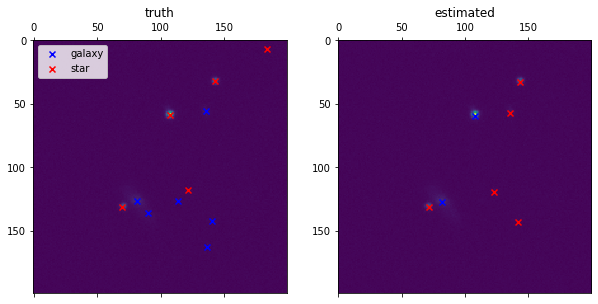

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

indx = 0

for i in range(2): 
    axes[i].matshow(_image[indx, 0].cpu())


axes[0].set_title('truth')
plot_locations(sdss_params_dict, indx, axes[0])
axes[0].legend()

axes[1].set_title('estimated')
plot_locations(est_params, indx, axes[1])